In this project, wa are asked to use image segmentation to identify the boundaries of a car in an image.

The training set contains 5088 of car images. Each car has 16 images taken at different angles, so we have 318 unique cars. We are also provided with the mask for each image in the training set. The test set contains 100 064 car images, again each car has 16 different images, so there are 6254 unique cars in the test set.

You can found the dataset [here](https://www.kaggle.com/c/carvana-image-masking-challenge/data?select=train.zip)

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential

In this notebook, I only used the training set (the test set is too big), this is why I commented the lines below.

In [2]:
from pathlib import Path
import zipfile

train_zip_path = '../input/carvana-image-masking-challenge/train.zip'
masks_zip_path = '../input/carvana-image-masking-challenge/train_masks.zip'
test_zip_path = '../input/carvana-image-masking-challenge/test.zip'

if not Path('/kaggle/working/train').exists():
    with zipfile.ZipFile(train_zip_path,'r') as z:
        z.extractall('/kaggle/working')
if not Path('/kaggle/working/train_masks').exists():
    with zipfile.ZipFile(masks_zip_path,'r') as z:
        z.extractall('/kaggle/working')
if not Path('/kaggle/working/test').exists():
    pass
    # with zipfile.ZipFile(test_zip_path,'r') as z:
    #    z.extractall('/kaggle/working')

# Analysis

How many images do we have in the training and test set

In [3]:
print("train set:  ", len(os.listdir("/kaggle/working/train")))
print("train masks:", len(os.listdir("/kaggle/working/train_masks")))
#print("test set:   ", len(os.listdir("/kaggle/working/test")))

train set:   5088
train masks: 5088


In [4]:
from glob import glob

root_dir = "/kaggle/working"
train_path = os.path.join(root_dir, "train")
train_masks_path = os.path.join(root_dir, "train_masks")
#test_path = os.path.join(root_dir, "test")

train_filepaths = glob(os.path.join(train_path, "*.jpg"))
train_masks_filepaths = glob(os.path.join(train_masks_path, "*.gif"))
#test_filepaths = glob(os.path.join(test_path, "*.jpg"))

# Get unique ids of images
def get_root_name(filepaths):
    file_names = [os.path.basename(filepath) for filepath in filepaths]
    root_name = [name.split("_")[0] for name in file_names]
    return root_name

all_train_ids = set(get_root_name(train_filepaths))
all_train_masks_ids = set(get_root_name(train_masks_filepaths))
#all_test_ids = set(get_root_name(test_filepaths))

How many different cars in training and test set

In [5]:
print("training set:       ", len(all_train_ids), " different cars")
print("training masks set: ", len(all_train_masks_ids), "different cars")
#print("test set:           ", len(all_test_ids), "different cars")

training set:        318  different cars
training masks set:  318 different cars


Display some cars with their masks

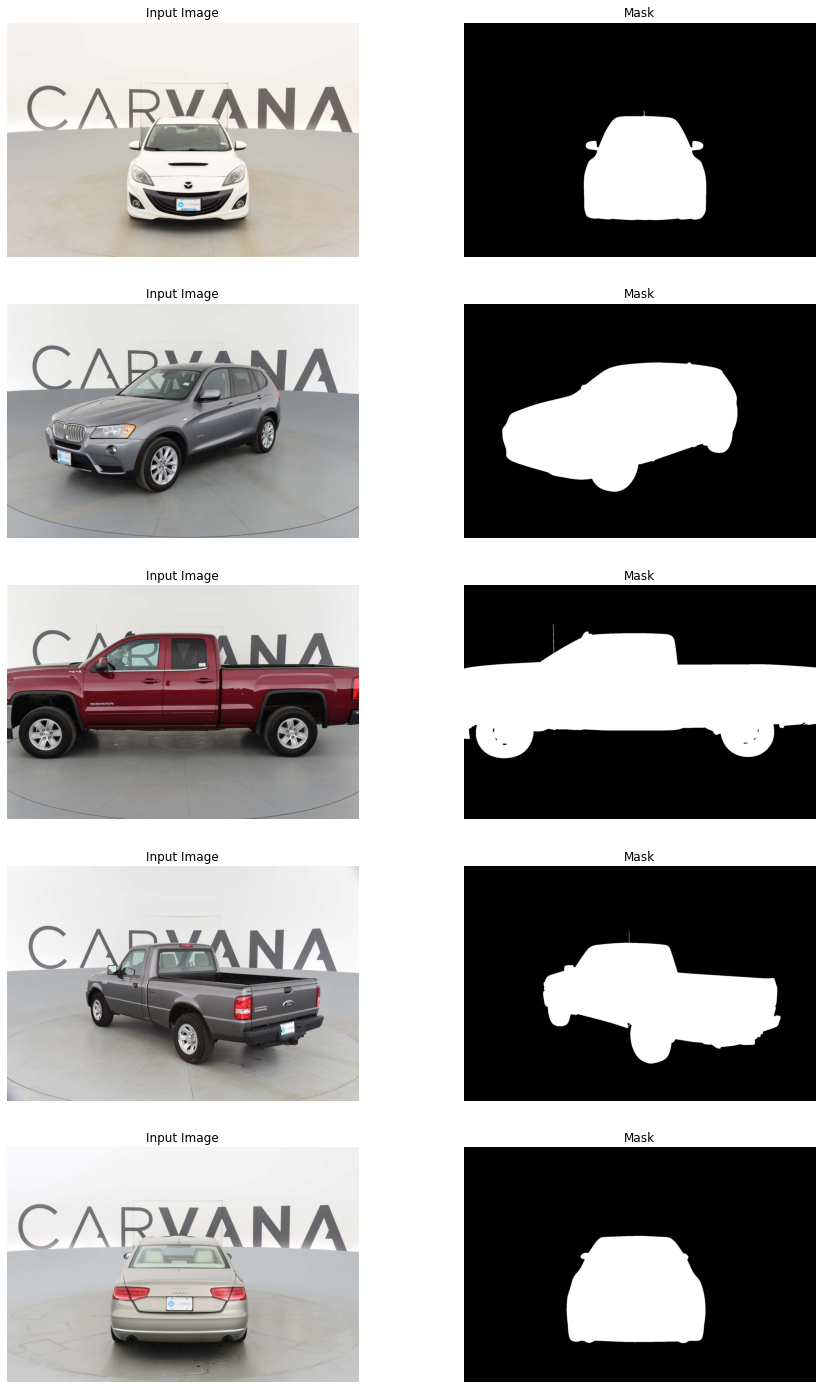

In [6]:
def display_images():
    plt.figure(figsize=(15, 25))
    title = ['Input Image', 'Mask']

    for i in range(0, 10, 2):
        plt.subplot(5, 2, i+1)
        plt.title(title[0])
        path_img = root_dir + "/train/" + list(all_train_ids)[i] + f"_0{i+1}.jpg"
        plt.imshow(imread(path_img))
        plt.axis("off")

        plt.subplot(5, 2, i+2)
        plt.title(title[1])
        path_mask_img = root_dir + "/train_masks/" + list(all_train_ids)[i] + f"_0{i+1}_mask.gif"
        plt.imshow(imread(path_mask_img))
        plt.axis("off")
    plt.show()

display_images()

# Training and Validation Split

We split the data by car to avoid overfitting single images.

In [7]:
def get_image_id(path):
    return os.path.splitext(os.path.basename(path))[0]

df = pd.DataFrame(dict(image_path=train_filepaths))
df['image_id'] = df['image_path'].map(lambda path: get_image_id(path))
df['mask_path'] = df['image_path'].map(
    lambda x: x.replace('train', 'train_masks').replace('.jpg', '_mask.gif'))
df['car_id'] = df['image_id'].map(lambda img_id: img_id.split('_')[0])

In [8]:
from sklearn.model_selection import train_test_split

def split_data(ids, col="car_id"):
    train_ids, valid_ids = train_test_split(ids, random_state=42, test_size=.2)
    valid_ids, test_ids = train_test_split(valid_ids, random_state=42, test_size=.5)
    train_df = df[df[col].isin(train_ids)]
    valid_df = df[df[col].isin(valid_ids)]
    test_df = df[df[col].isin(test_ids)]
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(list(all_train_ids))
print("train_df: ", train_df.shape[0])
print("valid_df: ", valid_df.shape[0])
print("test_df:  ", test_df.shape[0])

train_df:  4064
valid_df:  512
test_df:   512


In [9]:
train_df.head()

,image_path,image_id,mask_path,car_id
0,/kaggle/working/train/858841907a4a_07.jpg,858841907a4a_07,/kaggle/working/train_masks/858841907a4a_07_ma...,858841907a4a
1,/kaggle/working/train/371f057d1242_13.jpg,371f057d1242_13,/kaggle/working/train_masks/371f057d1242_13_ma...,371f057d1242
2,/kaggle/working/train/d61b6bfeabb2_13.jpg,d61b6bfeabb2_13,/kaggle/working/train_masks/d61b6bfeabb2_13_ma...,d61b6bfeabb2
3,/kaggle/working/train/880ab8468df2_15.jpg,880ab8468df2_15,/kaggle/working/train_masks/880ab8468df2_15_ma...,880ab8468df2
4,/kaggle/working/train/42a3297ccd4b_08.jpg,42a3297ccd4b_08,/kaggle/working/train_masks/42a3297ccd4b_08_ma...,42a3297ccd4b


# Preprocessing the data

Here, we build an input pipline using tf.data. We first load the data from the dataframe above, then we preprocess the image and the mask, and finally, we perform a simple data augmentation.

In [10]:
from tensorflow.image import stateless_random_crop, stateless_random_brightness

IMG_SIZE = [512, 512]
rng = tf.random.Generator.from_seed(1)

def decode(path):
    img = tf.io.read_file(path) 
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

@tf.function
def preprocess(image_path, mask_path):
    image = decode(image_path)
    mask = decode(mask_path)
    mask = mask[:, :, :1] # take one channel
    return image, mask

@tf.function
def data_augmentation(image, mask):
    if rng.uniform(()) > 0.5: 
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    seed = rng.make_seeds(2)[0]
    image = stateless_random_brightness(image, max_delta=0.1, seed=seed)
    return image, mask

def make_dataset(df, shuffle=False, augment=False, batch_size=16, buffer_size=1000):
    ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
    ds = ds.map(preprocess, num_parallel_calls=5)
    if shuffle:
        ds = ds.shuffle(buffer_size)
    if augment:
        ds = ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

train_data = make_dataset(train_df, shuffle=True, augment=True)
valid_data = make_dataset(valid_df)
test_data = make_dataset(test_df)

# Define the Model


In [11]:
def upsample(filters, size, strides, dropout=None):
    """Upsample the input"""

    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                      padding="same",
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if dropout:
        result.add(tf.keras.layers.Dropout(dropout))
    result.add(tf.keras.layers.ReLU())   
    return result

To have a better performance, I used the layers of the VGG19 as the encoder for the U-Net model. The decoder will be a series of the upsample block above.

In [12]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(input_shape=IMG_SIZE + [3], include_top=False, weights="imagenet")

layers_names = [
    "block2_conv1",    # 256x256
    "block2_conv2",    # 256x256
    "block3_conv1",    # 128x128
    "block3_conv2",    # 128x128
    "block4_conv1",    # 64x64
    "block4_conv2",    # 64x64
    "block5_conv1",    # 32x32
]

layers = [base_model.get_layer(name).output for name in layers_names]
down_stack = Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

up_stack = [
    upsample(512, 3, 1),   # 32x32 -> 32x32
    upsample(512, 3, 2),   # 32x32 -> 64x64
    upsample(256, 3, 1),   # 64x64 -> 64x64 
    upsample(256, 3, 2),   # 64x64 -> 128x128
    upsample(128, 3, 1),   # 128x128 -> 128x128
    upsample(128, 3, 2),   # 128x128 -> 256x256
]     

80142336/80134624 [==============================] - 1s 0us/step


# Build the U-Net model

In [13]:
keras.backend.clear_session()

def unet_generator(output_channels=1):
    inputs = tf.keras.layers.Input(shape=IMG_SIZE + [3])
    x = inputs

    initializer = tf.random_normal_initializer(0., 0.02)
    output = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, activation='sigmoid',
        padding="same", kernel_initializer=initializer
    )
    
    concat = tf.keras.layers.Concatenate()

    # Downsampling 
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connection
    for up, skip in zip (up_stack, skips):
        x = up(x)
        if up.layers[0].strides == (2, 2):
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

    x = output(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_generator()

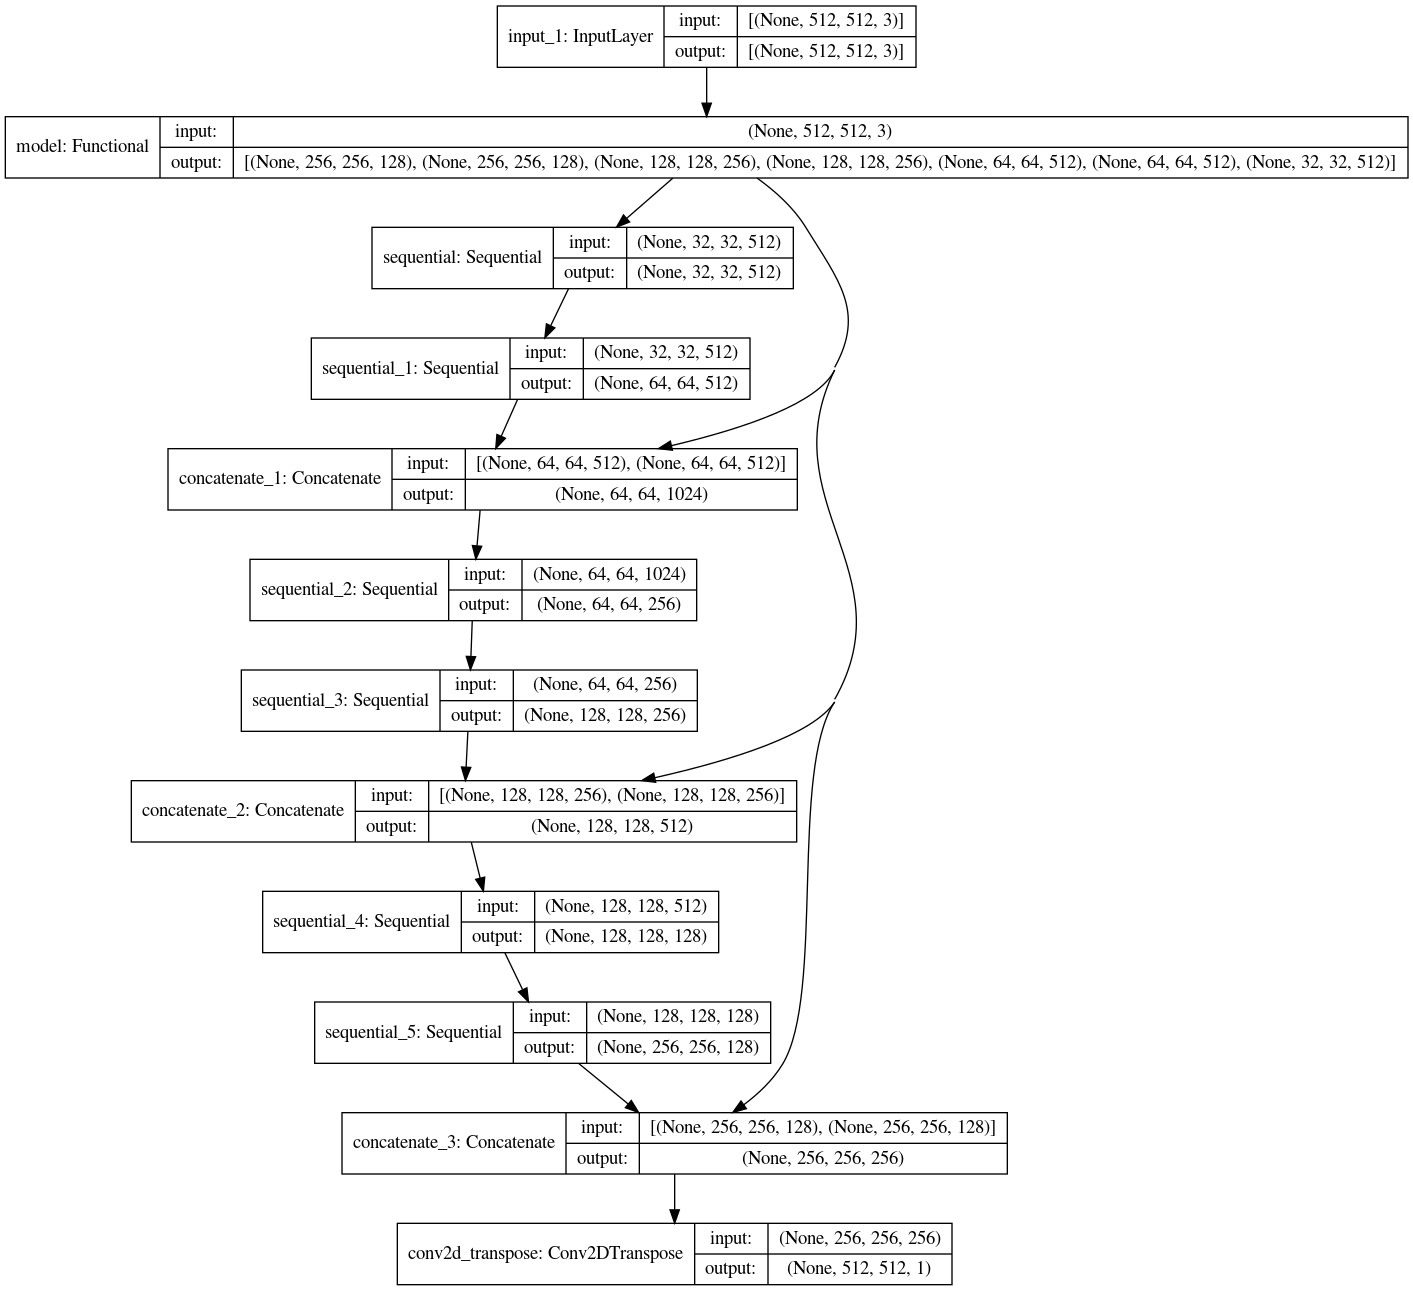

In [14]:
keras.utils.plot_model(model, show_shapes=True)

Here is what the model predict before training

In [15]:
for images, masks in train_data.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

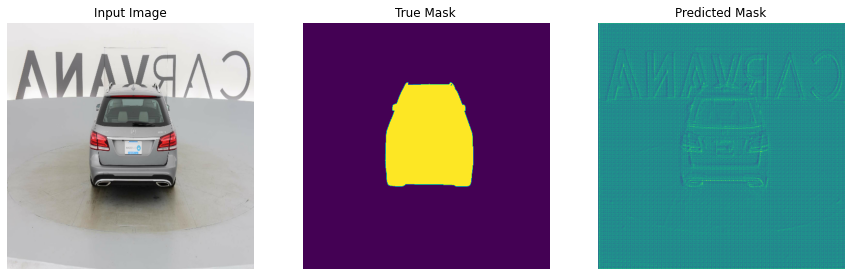

In [16]:
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(IMG_SIZE[0],IMG_SIZE[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)

# Losses

I saw in other kaggle kernels that users used the dice + binary cross-entropy loss but since only the binary cross-entropy gives me good results I didn't try the dice loss.

Epoch 1/10
254/254 [==============================] - 234s 795ms/step - loss: 0.1124 - accuracy: 0.9492 - val_loss: 0.0143 - val_accuracy: 0.9947
Epoch 2/10
254/254 [==============================] - 233s 806ms/step - loss: 0.0102 - accuracy: 0.9954 - val_loss: 0.0099 - val_accuracy: 0.9956
Epoch 3/10
254/254 [==============================] - 231s 808ms/step - loss: 0.0080 - accuracy: 0.9960 - val_loss: 0.0115 - val_accuracy: 0.9950
Epoch 4/10
254/254 [==============================] - 233s 816ms/step - loss: 0.0072 - accuracy: 0.9963 - val_loss: 0.0075 - val_accuracy: 0.9961
Epoch 5/10


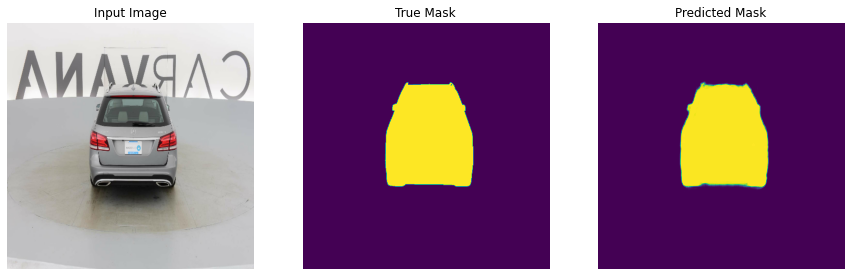

254/254 [==============================] - 237s 827ms/step - loss: 0.0064 - accuracy: 0.9965 - val_loss: 0.0070 - val_accuracy: 0.9964
Epoch 6/10
254/254 [==============================] - 239s 827ms/step - loss: 0.0064 - accuracy: 0.9965 - val_loss: 0.0073 - val_accuracy: 0.9962
Epoch 7/10
254/254 [==============================] - 240s 831ms/step - loss: 0.0057 - accuracy: 0.9968 - val_loss: 0.0063 - val_accuracy: 0.9966
Epoch 8/10
254/254 [==============================] - 238s 822ms/step - loss: 0.0053 - accuracy: 0.9969 - val_loss: 0.0064 - val_accuracy: 0.9965
Epoch 9/10
254/254 [==============================] - 236s 820ms/step - loss: 0.0052 - accuracy: 0.9969 - val_loss: 0.0060 - val_accuracy: 0.9967
Epoch 10/10


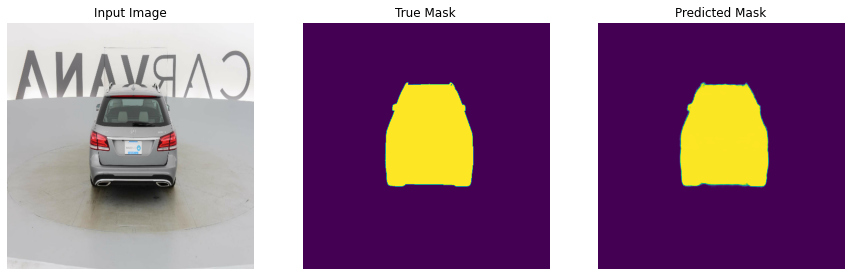

254/254 [==============================] - 233s 805ms/step - loss: 0.0051 - accuracy: 0.9970 - val_loss: 0.0063 - val_accuracy: 0.9966


In [17]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    restore_best_weights=True)

# Maybe needs to train for more epochs, but kaggle time is limited
epochs = 10

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions(sample_image, sample_mask)
    
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model_history = model.fit(train_data, epochs=epochs,
                          validation_data=valid_data,
                          callbacks=[DisplayCallback(), early_stopping_cb])

# Learning Curves

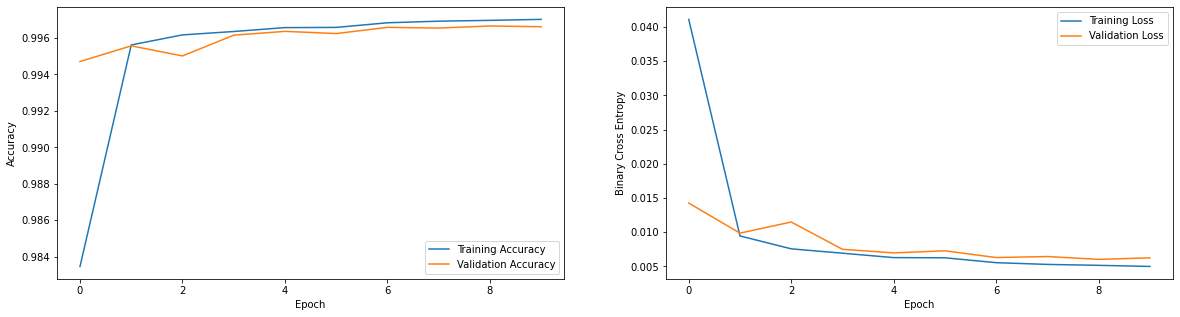

In [18]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend()
plt.show()

# Evaluation on the Test Set

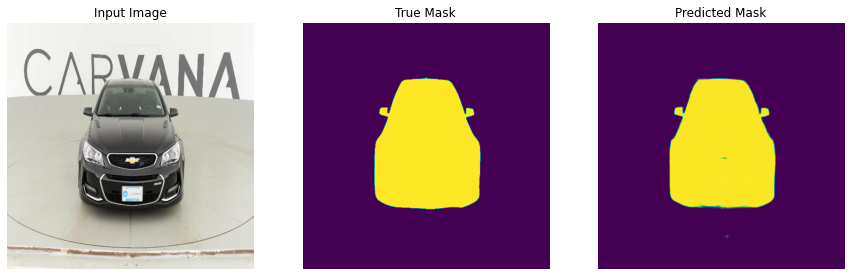

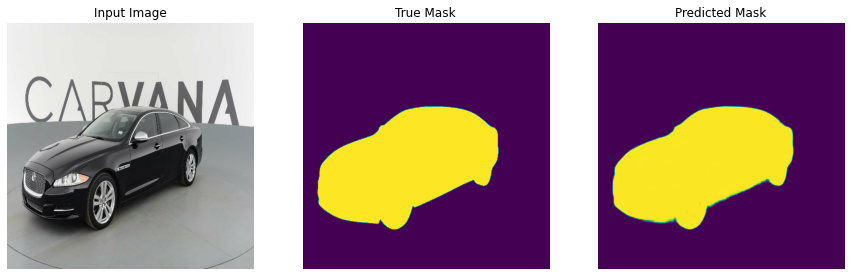

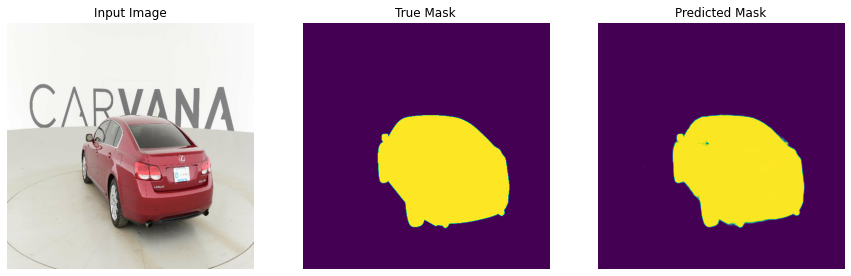

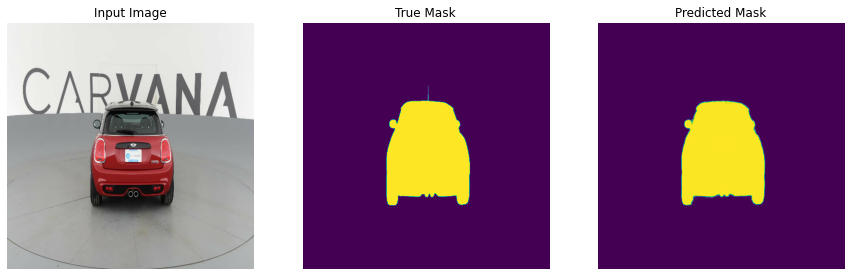

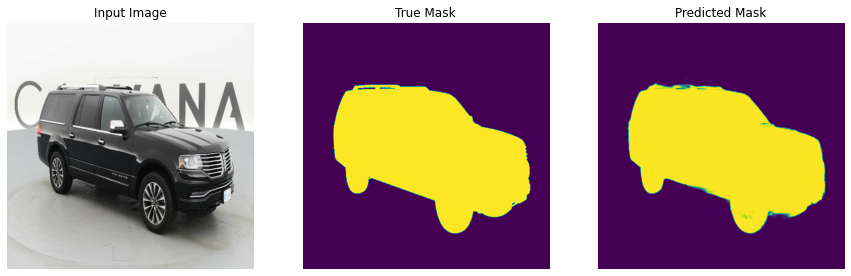

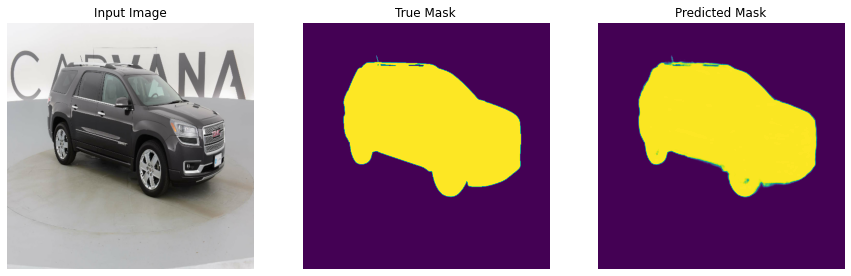

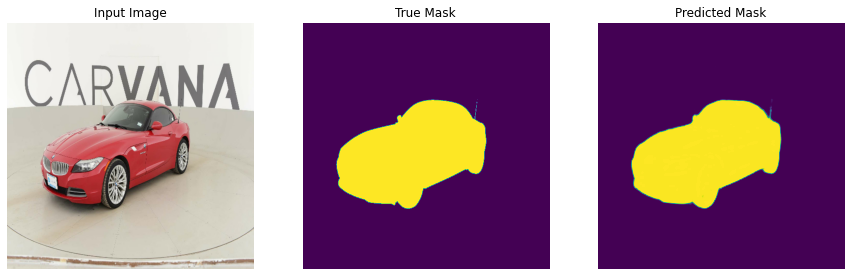

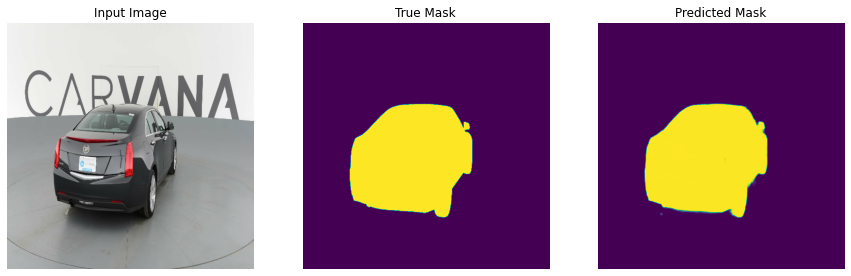

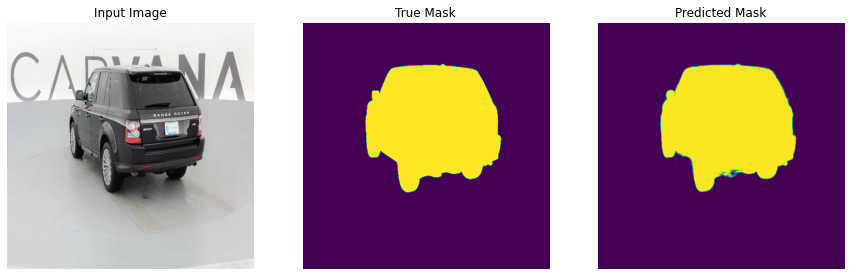

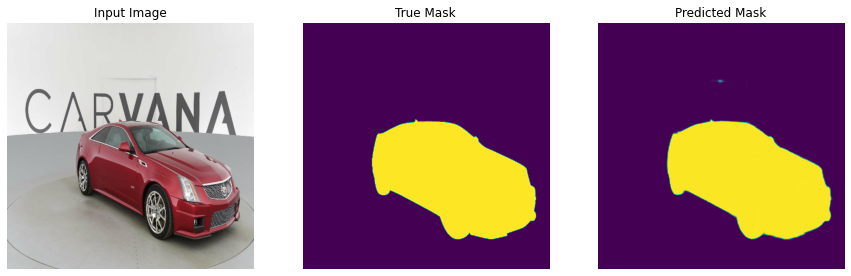

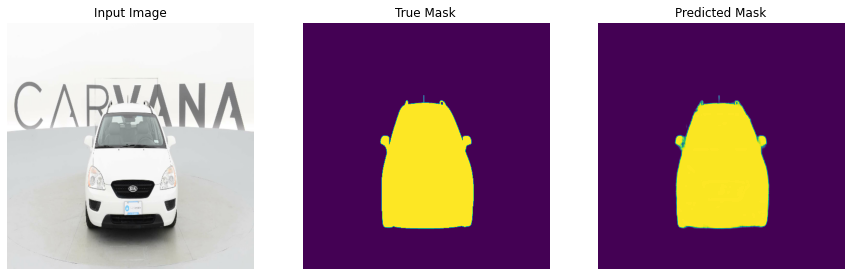

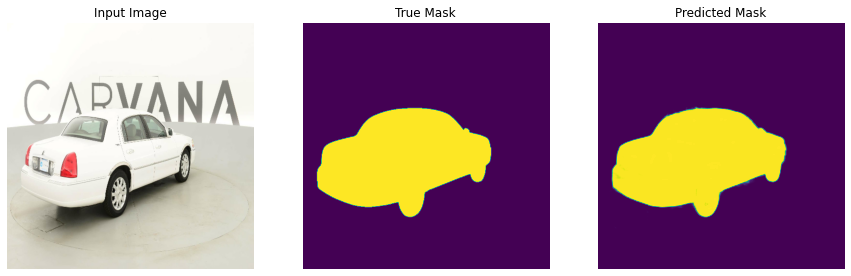

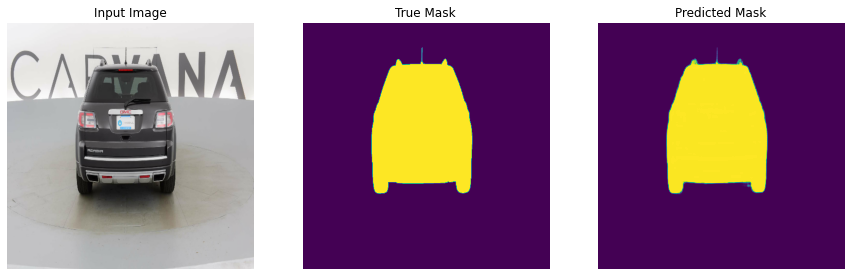

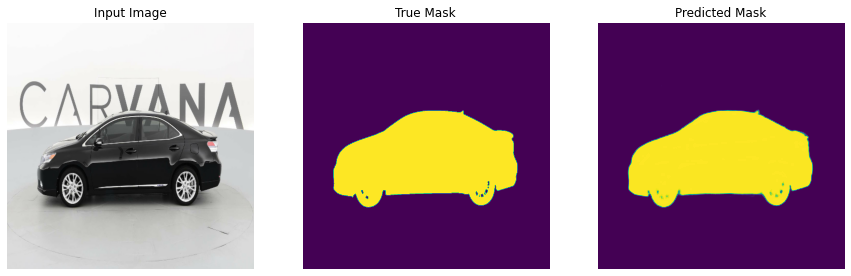

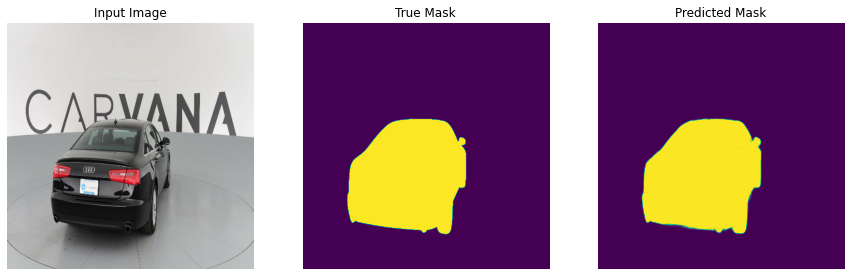

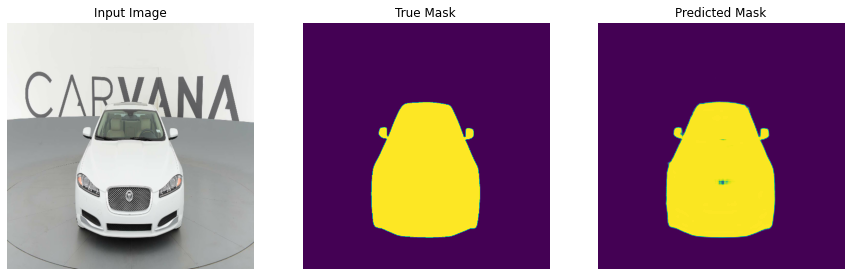

In [19]:
for images, masks in test_data.take(1):
    for img, mask in zip(images, masks):
        show_predictions(img, mask)

# Ressources

* [Image segmentation](https://www.tensorflow.org/tutorials/images/segmentation) tutorial from TensorFlow.
* [VGG16+U-Net on Carvana](https://www.kaggle.com/kmader/vgg16-u-net-on-carvana) kaggle kernel.
* [.99 loss - Simple Sol. using u-Net [Keras/TF] ](https://www.kaggle.com/phylake1337/99-loss-simple-sol-using-u-net-keras-tf) kaggle kernel.
* [Data visualization](https://www.kaggle.com/vfdev5/data-visualization) kaggle kernel.